In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
train_df = pd.read_csv("loan_train.csv")
test_df  = pd.read_csv("loan_test.csv")

df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

print(df.shape)
df.head()

(981, 12)


,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [ ]:
# حذف NaN
df = df.dropna()

# تبدیل Dependents (علت خطای قبلی)
df["Dependents"] = df["Dependents"].replace("3+", 3)
df["Dependents"] = df["Dependents"].astype(int)

# ستون‌های اسمی برای Label Encoding
categorical_cols = [
    "Gender",
    "Married",
    "Education",
    "Self_Employed",
    "Area",
    "Status"
]

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
X = df.drop("Status", axis=1)
y = df["Status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (349, 11)
X_test : (150, 11)


In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

baseline_acc = accuracy_score(y_test, y_pred)

print("Baseline Accuracy:", baseline_acc)
print("Number of Features:", X_train.shape[1])

Baseline Accuracy: 0.8
Number of Features: 11


In [ ]:
!pip install pyswarms

In [ ]:
import pyswarms as ps

n_features = X_train.shape[1]
alpha = 0.9

def pso_objective_function(particles):
    costs = []

    for particle in particles:
        mask = particle > 0.5

        if np.sum(mask) == 0:
            costs.append(1)
            continue

        X_tr = X_train.iloc[:, mask]
        X_te = X_test.iloc[:, mask]

        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42
        )
        model.fit(X_tr, y_train)
        y_pred = model.predict(X_te)

        acc = accuracy_score(y_test, y_pred)
        feature_ratio = np.sum(mask) / n_features

        cost = alpha * (1 - acc) + (1 - alpha) * (1 - feature_ratio)
        costs.append(cost)

    return np.array(costs)

In [ ]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = ps.single.GlobalBestPSO(
    n_particles=50,
    dimensions=n_features,
    options=options
)

best_cost, best_pos = optimizer.optimize(
    pso_objective_function,
    iters=100
)

pso_mask = best_pos > 0.5
pso_features = X_train.columns[pso_mask]

print("PSO Selected Features:", list(pso_features))
print("PSO Number of Features:", np.sum(pso_mask))

2026-02-03 12:35:31,761 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.171
2026-02-03 12:50:35,007 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.17109090909090915, best pos: [1.24533734 1.37043174 1.64843171 1.24546048 2.1637833  0.87997725
 1.28781648 0.47233586 0.95212723 1.15200606 0.51262666]


PSO Selected Features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Term', 'Credit_History', 'Area']
PSO Number of Features: 10


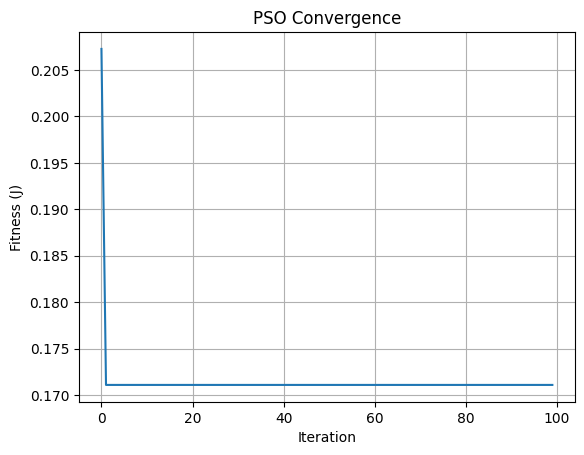

In [ ]:
plt.plot(optimizer.cost_history)
plt.xlabel("Iteration")
plt.ylabel("Fitness (J)")
plt.title("PSO Convergence")
plt.grid()
plt.show()

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 10.3 MB/s eta 0:00:00


In [ ]:
from deap import base, creator, tools, algorithms
import random

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def ga_fitness(individual):
    mask = np.array(individual, dtype=bool)

    if np.sum(mask) == 0:
        return (1,)

    X_tr = X_train.iloc[:, mask]
    X_te = X_test.iloc[:, mask]

    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_test, y_pred)
    feature_ratio = np.sum(mask) / n_features

    cost = alpha * (1 - acc) + (1 - alpha) * (1 - feature_ratio)
    return (cost,)

toolbox.register("evaluate", ga_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

population, logbook = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=0.9,
    mutpb=0.1,
    ngen=50,
    stats=stats,
    halloffame=hof,
    verbose=True
)

ga_mask = np.array(hof[0], dtype=bool)
ga_features = X_train.columns[ga_mask]

print("GA Selected Features:", list(ga_features))
print("GA Number of Features:", np.sum(ga_mask))

gen	nevals	min     
0  	50    	0.186182
1  	50    	0.186182
2  	44    	0.186182
3  	48    	0.186182
4  	48    	0.171091
5  	48    	0.171091
6  	48    	0.171091
7  	37    	0.171091
8  	46    	0.171091
9  	46    	0.171091
10 	42    	0.171091
11 	48    	0.171091
12 	45    	0.171091
13 	46    	0.171091
14 	42    	0.171091
15 	48    	0.171091
16 	47    	0.171091
17 	42    	0.171091
18 	43    	0.171091
19 	45    	0.171091
20 	48    	0.171091
21 	46    	0.171091
22 	46    	0.171091
23 	40    	0.171091
24 	42    	0.171091
25 	46    	0.171091
26 	42    	0.171091
27 	46    	0.171091
28 	50    	0.171091
29 	46    	0.171091
30 	47    	0.171091
31 	46    	0.171091
32 	43    	0.171091
33 	48    	0.171091
34 	43    	0.171091
35 	40    	0.171091
36 	49    	0.171091
37 	46    	0.171091
38 	45    	0.171091
39 	48    	0.171091
40 	46    	0.171091
41 	47    	0.171091
42 	45    	0.171091
43 	50    	0.171091
44 	48    	0.171091
45 	46    	0.171091
46 	46    	0.171091
47 	45    	0.171091
48 	44    	0.171091


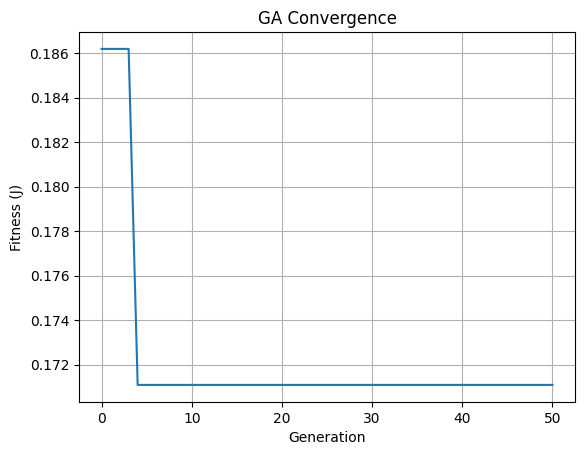

In [ ]:
plt.plot(logbook.select("min"))
plt.xlabel("Generation")
plt.ylabel("Fitness (J)")
plt.title("GA Convergence")
plt.grid()
plt.show()

In [ ]:
print("Baseline Accuracy:", baseline_acc)
print("PSO Features:", len(pso_features))
print("GA Features:", len(ga_features))

Baseline Accuracy: 0.8
PSO Features: 10
GA Features: 10
